In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import * 
from models_gnn import * 
from graph import get_delaunay_graph

In [8]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [9]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [10]:
def ddp_setup(rank: int, world_size: int):
  """
  Args:
      rank: Unique identifier of each process
     world_size: Total number of processes
  """
  os.environ["MASTER_ADDR"] = "localhost"
  os.environ["MASTER_PORT"] = "12355"
  init_process_group(backend="nccl", rank=rank, world_size=world_size)

In [4]:
DATA_PATH = '../matrix_dataset/'

train_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Train.mat')
train_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Train.mat')
test_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Test.mat')
test_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

In [5]:
train_A_chars = list(train_A_raw['TargetChar'][0])
train_B_chars = list(train_B_raw['TargetChar'][0])
test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')
test_B_chars = list('MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR')

In [6]:
A_train_ds = P300Getter(train_A_raw, eloc)
A_test_ds = P300Getter(test_A_raw, eloc, target_chars=test_A_chars)

A_train_ds.get_cnn_p300_dataset(filter=True)
A_test_ds.get_cnn_p300_dataset(filter=True)

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.18it/s]


In [7]:
B_train_ds = P300Getter(train_B_raw, eloc)
B_test_ds = P300Getter(test_B_raw, eloc, target_chars=test_B_chars)

B_train_ds.get_cnn_p300_dataset(filter=True)
B_test_ds.get_cnn_p300_dataset(filter=True)

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 21.75it/s]


In [8]:
X_train_B, y_train_B = B_train_ds.get_data()
X_test_B, y_test_B = B_test_ds.get_data()

In [9]:
train_B_dataset = CNNMatrixDataset(tensors=(X_train_B, y_train_B), with_target=True, transform=None)
test_B_dataset = CNNMatrixDataset(tensors=(X_test_B, y_test_B), with_target=True, transform=None)

batch_size = 180 #256

train_B_CNN = DataLoader(train_B_dataset, batch_size=batch_size) # , shuffle=True
test_B_CNN = DataLoader(test_B_dataset, batch_size=batch_size) # , shuffle=True

data_loaders_CNN_B = {'train':train_B_CNN, 'val':test_B_CNN}

In [10]:
X_train_A, y_train_A = A_train_ds.get_data()
X_test_A, y_test_A = A_test_ds.get_data()

In [22]:
train_A_dataset = CNNMatrixDataset(tensors=(X_train_A, y_train_A), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(X_test_A, y_test_A), with_target=True, transform=None)

batch_size = 180 #256

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, 
                        sampler=DistributedSampler(test_A_dataset)) # , shuffle=True
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, 
                        sampler=DistributedSampler(test_A_dataset)) # , shuffle=True

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

RuntimeError: Default process group has not been initialized, please make sure to call init_process_group.

In [20]:
model = DDP(model_CNN, device_ids=[0, 1])

ValueError: device_ids can only be None or contain a single element.

In [ ]:
def main(rank, world_size):
    dataset, model, optimizer = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size=32)
    trainer = Trainer(model, train_data, optimizer, rank, save_every)
    trainer.train(total_epochs)
    destroy_process_group()

    
world_size = torch.cuda.device_count()
mp.spawn(main, args=(world_size,), nprocs=world_size)

In [16]:
criterion = nn.BCEWithLogitsLoss() #nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3)) weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 100,
    'lr' : 1e-3,
    'weight_decay' : 0,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

#model_CNN = CNN1(72, n_channels=64)
A = torch.tensor(get_delaunay_graph(eloc).toarray()).to(my_device)
#B = B.to(my_device)
#model_CNN = BaseCNNAttn(72, 64, A)
model_CNN = BaseCNNAttn(72, 64)

loss, acc, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, device=my_device)

cuda:0
Epoch 9/99
----------
train Loss: 3.9231 Acc: 0.7886 Ones: 12.3529
val Loss: 1.3929 Acc: 0.8123 Ones: 6.1200
Epoch 19/99
----------
train Loss: 5.3716 Acc: 0.7896 Ones: 10.7882
val Loss: 2.3716 Acc: 0.8112 Ones: 6.4700
Epoch 29/99
----------
train Loss: 3.4214 Acc: 0.8012 Ones: 9.1529
val Loss: 0.4978 Acc: 0.8333 Ones: 0.0000
Epoch 39/99
----------
train Loss: 5.9356 Acc: 0.7949 Ones: 10.6353
val Loss: 0.5082 Acc: 0.8324 Ones: 0.2200
Epoch 49/99
----------
train Loss: 7.6484 Acc: 0.7928 Ones: 11.2471
val Loss: 3.4197 Acc: 0.8038 Ones: 7.8300
Epoch 59/99
----------
train Loss: 2.7165 Acc: 0.7944 Ones: 9.7529
val Loss: 0.6681 Acc: 0.8283 Ones: 1.4300
Epoch 69/99
----------
train Loss: 1.9650 Acc: 0.8023 Ones: 8.6235
val Loss: 1.2992 Acc: 0.8141 Ones: 5.0200
Epoch 79/99
----------
train Loss: 1.3828 Acc: 0.8041 Ones: 7.6353
val Loss: 0.4595 Acc: 0.8333 Ones: 0.0000
Epoch 89/99
----------
train Loss: 1.2705 Acc: 0.8181 Ones: 4.3647
val Loss: 0.6698 Acc: 0.8319 Ones: 0.4800
Epoch 99/

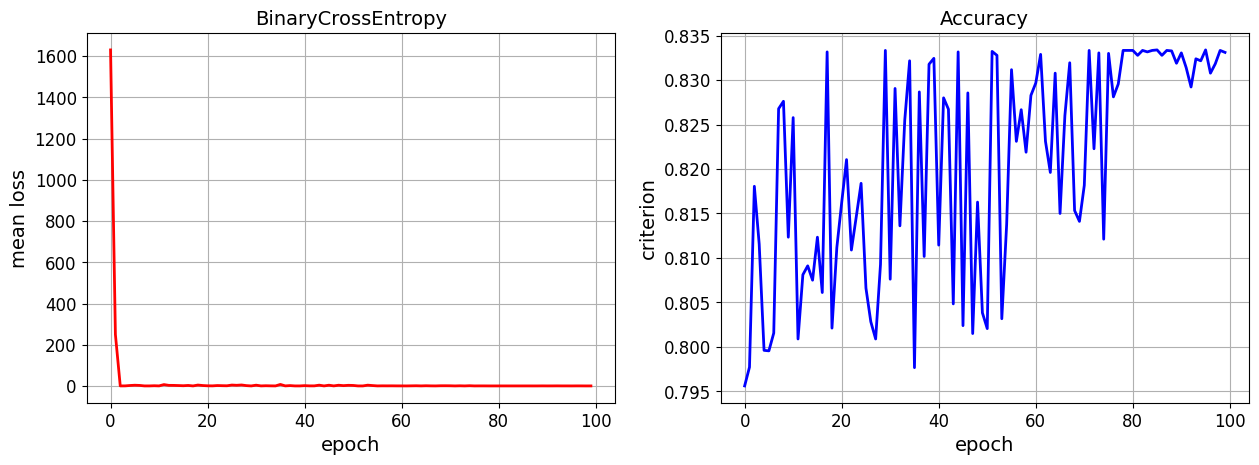

In [17]:
show_progress(loss, acc, 'BinaryCrossEntropy', 'Accuracy')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-62-0c266b42eae3>:3: FutureWarning: The "show_names" parameter is deprecated and will be removed in version 1.3. Use the "names" parameter instead.
  names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)


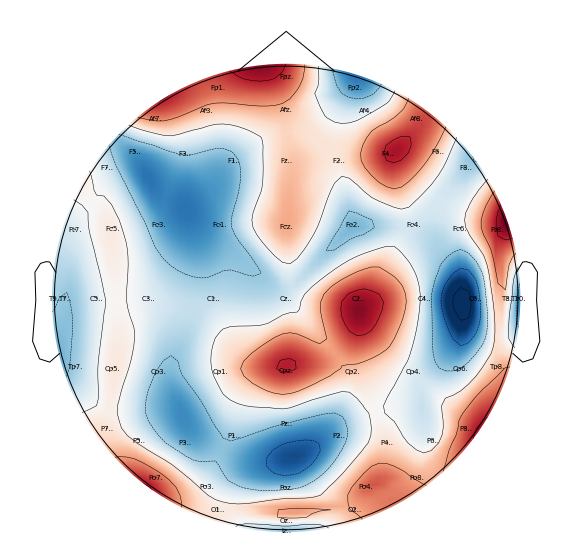

In [ ]:
channel_weights = np.array(model_CNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=eloc.ch_names, show_names=True) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()